In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')


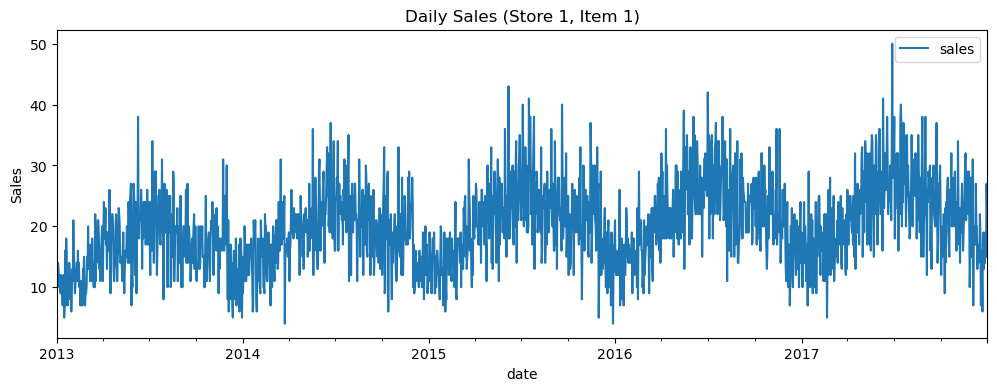

In [5]:
df = pd.read_csv("train.csv", parse_dates=["date"]) 
# interpret the column named "date" in your CSV file as datetime objects, rather than just strings
df = df[df['store'] == 1]  # Focus on one store: Only the rows where the boolean Series is True are kept
df = df[df['item'] == 1]   # Focus on one item
df = df.sort_values("date").set_index("date") # ascending order -> sets the 'date' column as the DataFrame's index
df = df.asfreq("D")  # Ensure daily frequency
df = df[['sales']] # selects only the 'sales' column from the DataFrame (but still a df using [[]])

df.plot(title="Daily Sales (Store 1, Item 1)", figsize=(12,4))
plt.ylabel("Sales")
plt.show()


In [6]:
def create_features(df, lags=[1, 7, 14], roll_windows=[7, 30]): # the number of past time steps/ "rolling" (moving) aggregate features
    for lag in lags:
        df[f'lag_{lag}'] = df['sales'].shift(lag) 
        # column name is dynamically generated using an f-string, e.g., 'lag_1', 'lag_7', 'lag_14'
        # lag_1 will contain the sales from the previous day, etc
    for window in roll_windows:
        df[f'roll_mean_{window}'] = df['sales'].shift(1).rolling(window).mean()
        # prevent data leakage by shifting by 1 day -> new column 
        # Rolling average features help the model capture trends or seasonality over longer periods
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    return df

df = create_features(df)
df.dropna(inplace=True)


In [7]:
split_date = "2017-01-01"
train = df.loc[:split_date]
test = df.loc[split_date:]

X_train, y_train = train.drop('sales', axis=1), train['sales']
X_test, y_test = test.drop('sales', axis=1), test['sales']

print(f"Training data: {X_train.shape}")
print(f"Testing data: {X_test.shape}")


Training data: (1432, 7)
Testing data: (365, 7)


In [8]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
# 100 trees will be sequentially added to the ensemble
# max_depth constrains the complexity of each individual tree
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

RMSE: 5.28


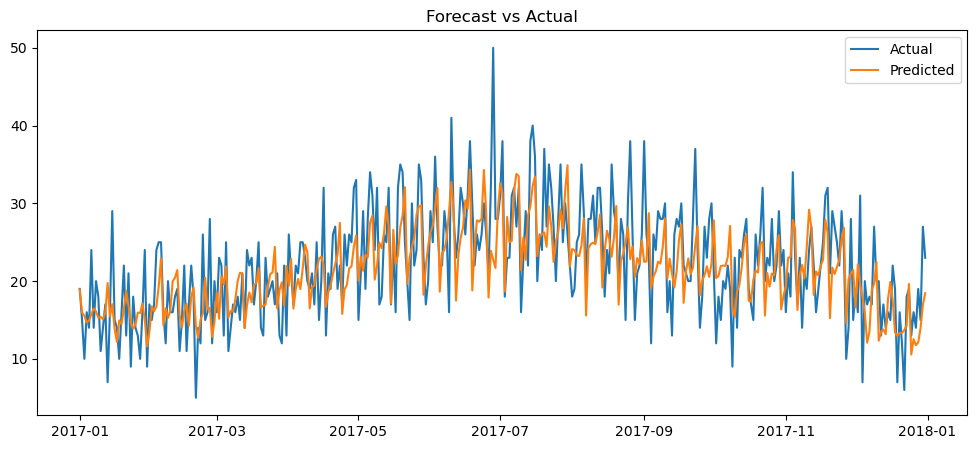

In [9]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.title("Forecast vs Actual")
plt.legend()
plt.show()


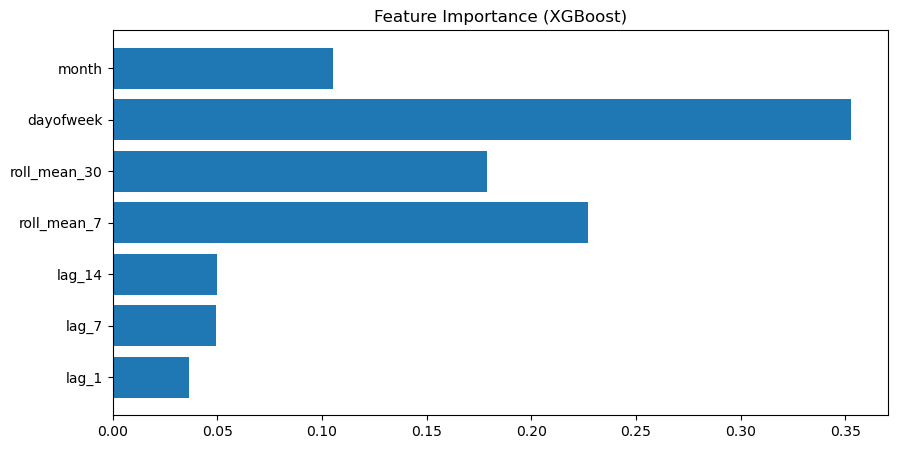

In [10]:
# Visualize how much each feature contributed to model predictions.
# Helps guide further feature engineering or simplification.
importances = model.feature_importances_
features = X_train.columns

plt.figure(figsize=(10,5))
plt.barh(features, importances)
plt.title("Feature Importance (XGBoost)")
plt.show()
